In [0]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import xgboost as xgb
from tqdm import tqdm
import keras
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline,linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sn


Using TensorFlow backend.


In [0]:
!wget https://propaganda.qcri.org/semeval2020-task11/data/datasets-v2.tgz
!tar xzvf datasets-v2.tgz

In [0]:
train_articles = os.listdir("datasets/train-articles")
train_labels_tags_span = os.listdir("datasets/train-labels-task1-span-identification")
train_tags_technique = os.listdir("datasets/train-labels-task2-technique-classification")
train_articles.sort()
train_labels_tags_span.sort()

Step 1: Gather tables from Task 1 folder and place them into a dict type where the article number is the key

In [0]:
# Dictionary containing news articlc
propTagsSpan = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task1-span-identification/"+ articleNoExt + ".task1-SI.labels"
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsSpan[articleNoExt] = tags
    r.close()
    
print(propTagsSpan[train_articles[0]])
    

['111111111 265 323 ', '111111111 1795 1935 ', '111111111 149 157 ', '111111111 1069 1091 ', '111111111 1334 1462 ', '111111111 1577 1616 ', '111111111 2023 2086 ']


Step 2: Do the same for task 2

In [0]:
propagandaTagTechnique = os.listdir("datasets/train-labels-task2-technique-classification")
propagandaTagTechnique.sort()
propTagsTechnique = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task2-technique-classification/"+ articleNoExt + ".task2-TC.labels"
    
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace(articleNo, " ")
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsTechnique [articleNoExt] = tags
    r.close()
    
print(propTagsTechnique[train_articles[0]])
    

['  Appeal_to_Authority 265 323 ', '  Appeal_to_Authority 1795 1935 ', '  Doubt 149 157 ', '  Repetition 1069 1091 ', '  Appeal_to_fear-prejudice 1334 1462 ', '  Appeal_to_fear-prejudice 1577 1616 ', '  Appeal_to_fear-prejudice 1856 1910 ', '  Appeal_to_fear-prejudice 2023 2086 ']


Step 3: Put sentences that have annotation "propoganda" as a list

In [0]:
propoganda_sent_span = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsSpan[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            
            propoganda_sent_span.append(tag_line)
    r.close()

print(propoganda_sent_span[0])

The next transmission could be more pronounced or stronger


Step 4: Create a dictionary with the keys being the propoganda sentences and the values being their associated propoganda type. 

In [0]:
propoganda_techniques = {}
propoganda_techniques["Sentence"] = []
propoganda_techniques["Technique"] = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsTechnique[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            propoganda_techniques["Technique"].append(tag[0])
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            propoganda_techniques["Sentence"].append(tag_line)     
    r.close()  

Step 5: Using the list of propoganda sentences to create a list of non propoganda sentences

Step 6: Convert dictionary into DataFrame


In [0]:
df = pd.DataFrame.from_dict(propoganda_techniques)
df

,Sentence,Technique
0,The next transmission could be more pronounced...,Appeal_to_Authority
1,when (the plague) comes again it starts from m...,Appeal_to_Authority
2,appeared,Doubt
3,"a very, very different",Repetition
4,He also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice
...,...,...
6124,the Left killed comedy,Slogans
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation"
6126,Columbia snowflakes,"Name_Calling,Labeling"
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation"


Step 7: Plot data per class


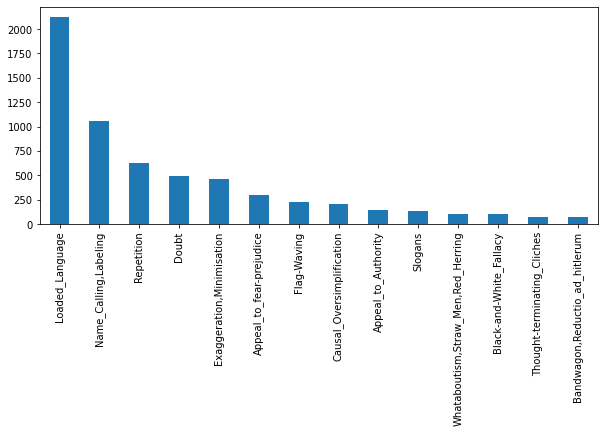

In [0]:
propoganda_techniques_tags = ['Appeal_to_Authority','Name_Calling,Labeling','Slogans', 'Loaded_Language','Appeal_to_fear-prejudice','Repetition','Doubt','Exaggeration,Minimisation','Flag-Waving','Causal_Oversimplification','Whataboutism,Straw_Men,Red_Herring','Black-and-White_Fallacy','Thought-terminating_Cliches','Bandwagon,Reductio_ad_hitlerum']
plt.figure(figsize=(10,4))
df.Technique.value_counts().plot(kind='bar');

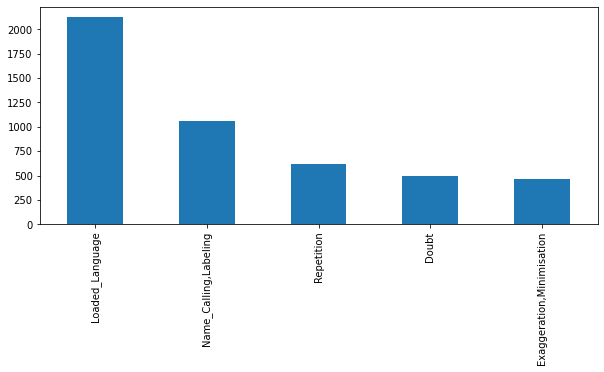

In [0]:
import numpy as np 
df = df[np.logical_not(df['Technique'].isin(['Appeal_to_Authority','Slogans','Appeal_to_fear-prejudice','Flag-Waving','Causal_Oversimplification','Whataboutism,Straw_Men,Red_Herring','Black-and-White_Fallacy','Thought-terminating_Cliches','Bandwagon,Reductio_ad_hitlerum']))]
plt.figure(figsize=(10,4))
df.Technique.value_counts().plot(kind='bar');

In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Step 10: Prepocessing - even if the data is very clean #to check

---



In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]') 
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text - not sure if we want to do this
    return text
    
df['Sentence'] = df['Sentence'].apply(clean_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


step 11: Count number of token post preprocessing

In [0]:
df['Sentence'].apply(lambda x: len(x.split(' '))).sum()

17190

Vectorizing df['Sentence'] with tfidf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df.Sentence
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
X.shape

(4761, 5922)

Vectorizing df['Technique'] with labelencoder

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df['Technique'])
y = le.transform(df['Technique'])
y.shape

(4761,)

Check the techniques by inverse tranforming them

In [0]:
set(le.inverse_transform(y))

{'Doubt',
 'Exaggeration,Minimisation',
 'Loaded_Language',
 'Name_Calling,Labeling',
 'Repetition'}

Step 12: split the training data into train and test sets

In [0]:
#random_state sets a seed, the train-test splits are always deterministic. If the seed is not set, train-test splits are different each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 

SMOTE () the classes, with 'not majority' resample all classes but the majority class

In [0]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import numpy as np 
smote = SMOTE('not majority')

x_smote, y_smote = smote.fit_sample(X_train, y_train)
x_smote.shape, y_smote.shape

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


((8390, 5922), (8390,))

Create a ML pipeline where we stack the Sentence vectorisation (TFIDF, CountVec) and the model - This structure will repaet later but we'll change the models **with the original x_train and y_train**

In [0]:
from sklearn.metrics import precision_score
nb =  MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  58.02728226652676
Precision:  0.6686235708003518
Recall:  0.35940701052156054
F1 score:  0.374817600975269


Plotting heatmap to evaluate each class: only 6 classes are considered


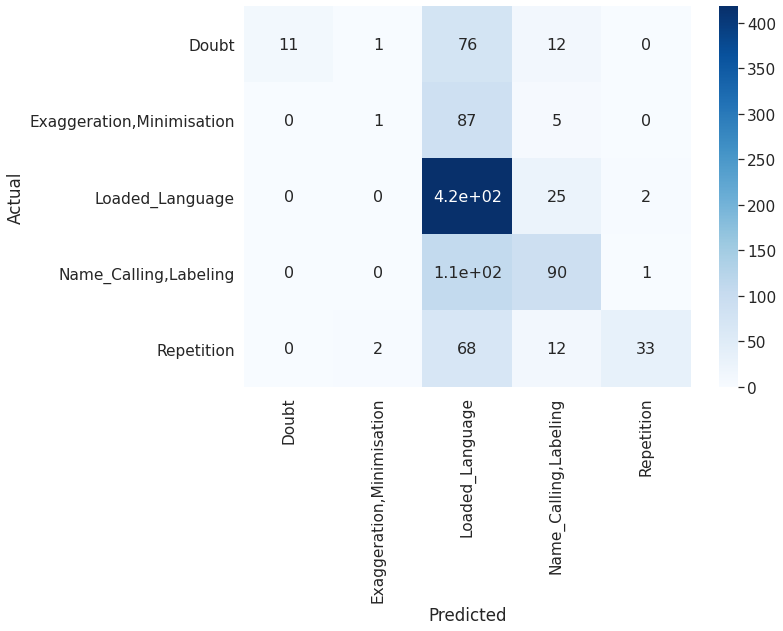

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font siz

Logistic regression **with the original x_train and y_train**

In [0]:
from sklearn.linear_model import LogisticRegression

logreg =  LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  60.020986358866736
Precision:  0.6671866539257844
Recall:  0.4050482689065036
F1 score:  0.4462984995173603


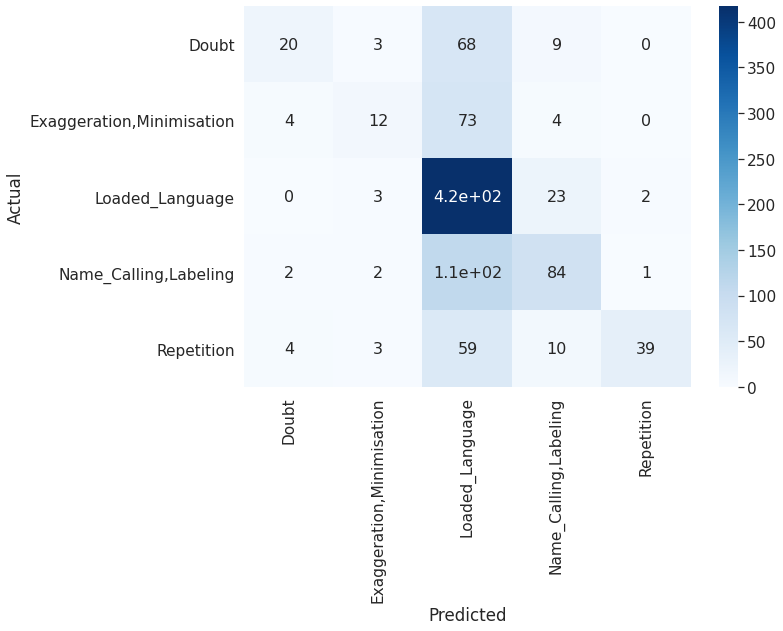

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font siz

SGDClassifier **with the original x_train and y_train**

> Indented block



In [0]:
from sklearn.linear_model import SGDClassifier

sgd =  SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

# Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  61.59496327387198
Precision:  0.6606409107131578
Recall:  0.43317047239337925
F1 score:  0.47941299561756845


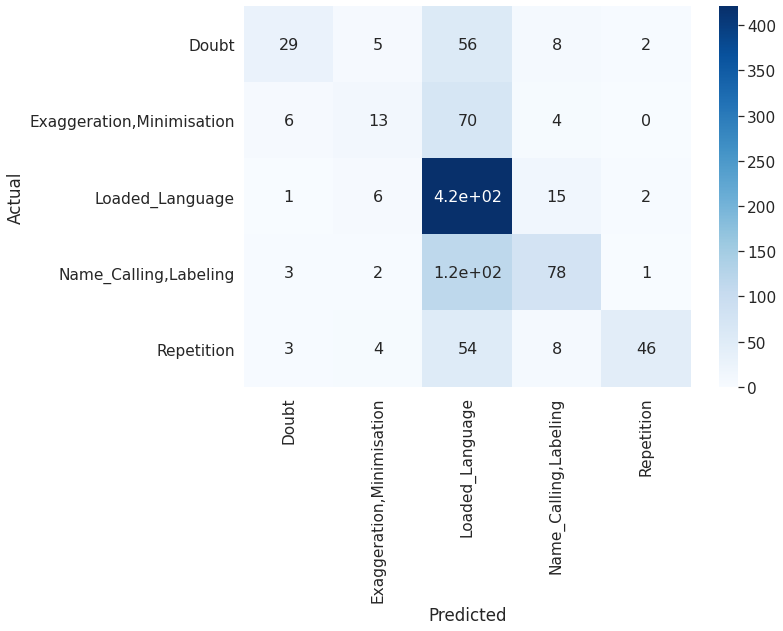

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font siz

Naive Bayes ** SMOTE x_train and y_train data**


In [0]:
clf = MultinomialNB()
clf.fit(x_smote, y_smote)

y_pred = clf.predict(X_test)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  46.904512067156354
Precision:  0.4600974154600654
Recall:  0.5241255128144517
F1 score:  0.4545098119639075


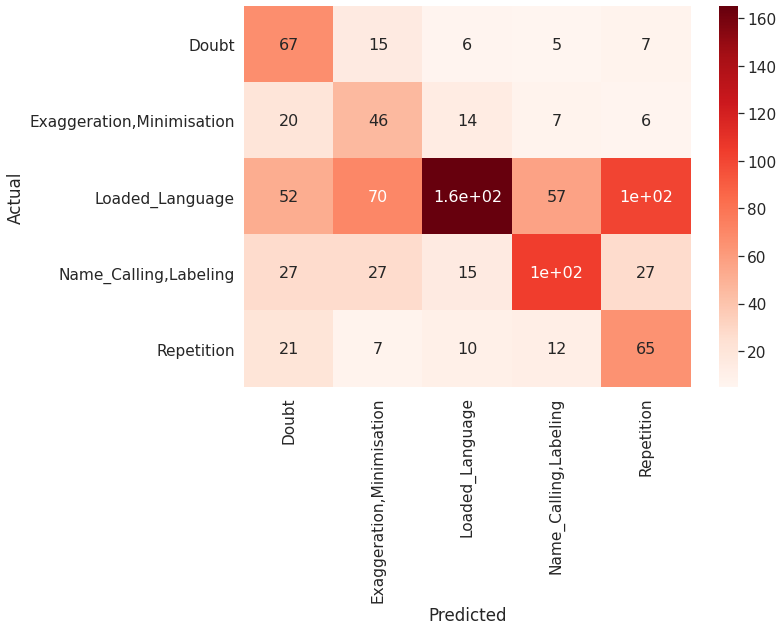

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font siz

LogisticRegression ** SMOTE x_train and y_train data**

In [0]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(x_smote, y_smote)

y_pred = clf.predict(X_test)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  62.01469045120671
Precision:  0.5587381461702722
Recall:  0.5711149597365145
F1 score:  0.5583061825378517


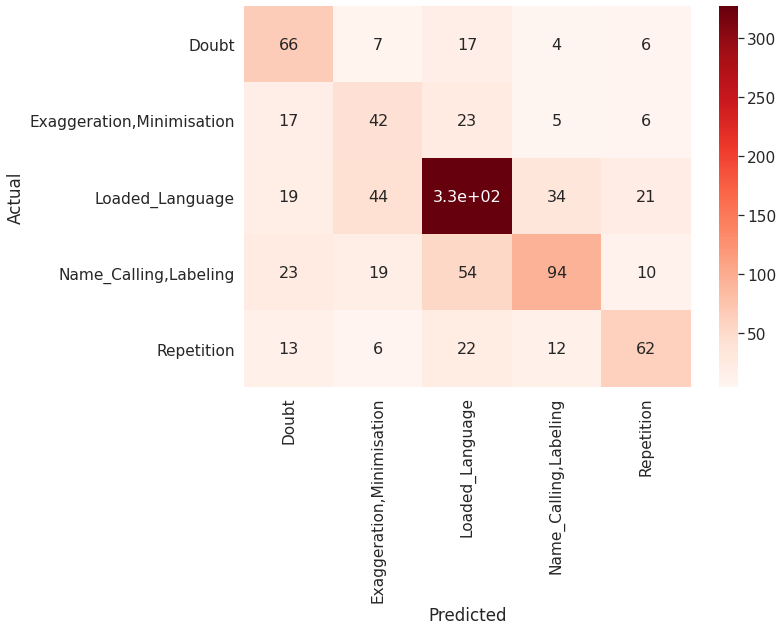

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font siz

SGDClassifier ** SMOTE x_train and y_train data**

In [0]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(x_smote, y_smote)

y_pred = sgd.predict(X_test)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  48.58342077649528
Precision:  0.4799977257213685
Recall:  0.5477178666918807
F1 score:  0.47136435104805435


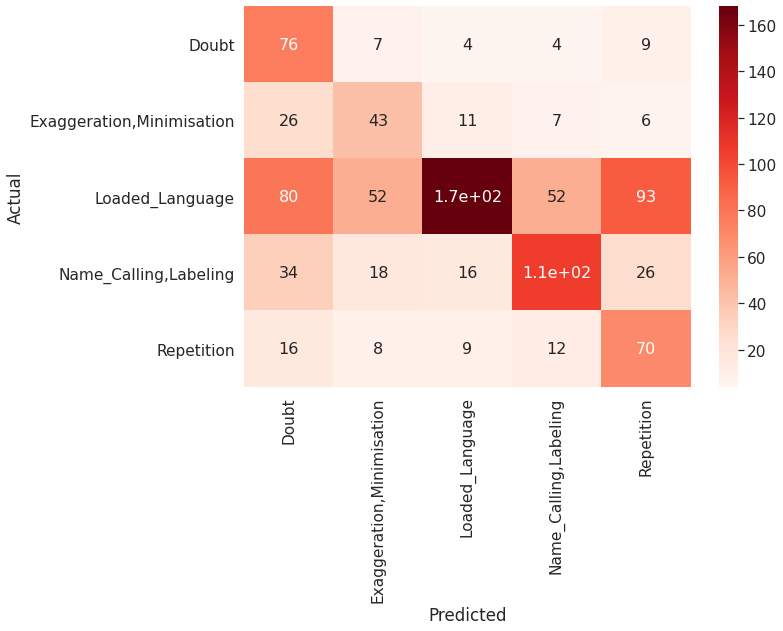

In [0]:
y_test_plot = list(le.inverse_transform(y_test))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font siz

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
!ls
!pwdn

--2020-04-04 04:16:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-04 04:16:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-04 04:16:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")
model_news = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt', binary=False)
model_news.save_word2vec_format('glove.6B.100d.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from nltk import word_tokenize
nltk.download('punkt')
review_embeddings = []
for each_review in df.Sentence:
    Review_average = np.zeros(model_news.vector_size)
    count_val = 1
    
    for each_word in word_tokenize(each_review):       
        if(each_word.lower() in model_news):
            Review_average =+ model_news[each_word.lower()]
            count_val += 1
    
    review_embeddings.append(list(Review_average/count_val))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
embedding_data = pd.DataFrame(review_embeddings)
embedding_data = embedding_data.fillna(0)
print(embedding_data.shape)

le = preprocessing.LabelEncoder()
le.fit(df['Technique'])
y = le.transform(df['Technique'])
print(y.shape)
X_train_embed_news, X_test_embed_news, y_train_embed_news, y_test_embed_news =  \
                            train_test_split(embedding_data,y,test_size = 0.2,random_state = 0)

(4761, 100)
(4761,)


Linear regression with word embeddings

In [0]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train_embed_news, y_train_embed_news)

y_pred = sgd.predict(X_test_embed_news)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test_embed_news, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test_embed_news, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  50.99685204616999
Precision:  0.4210505008991806
Recall:  0.37662157031827687
F1 score:  0.38138086548610795


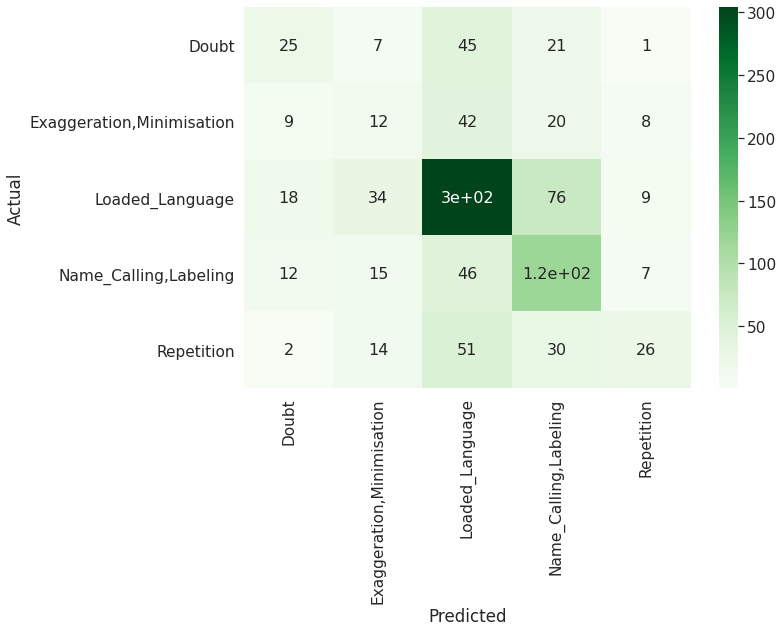

In [0]:
y_test_plot = list(le.inverse_transform(y_test_embed_news))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 16})# font siz

Logistic regression with word embeddings

In [0]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(X_train_embed_news, y_train_embed_news)

y_pred = clf.predict(X_test_embed_news)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test_embed_news, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test_embed_news, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  55.613850996852044
Precision:  0.4679589564714126
Recall:  0.4110061384307177
F1 score:  0.419755610223716


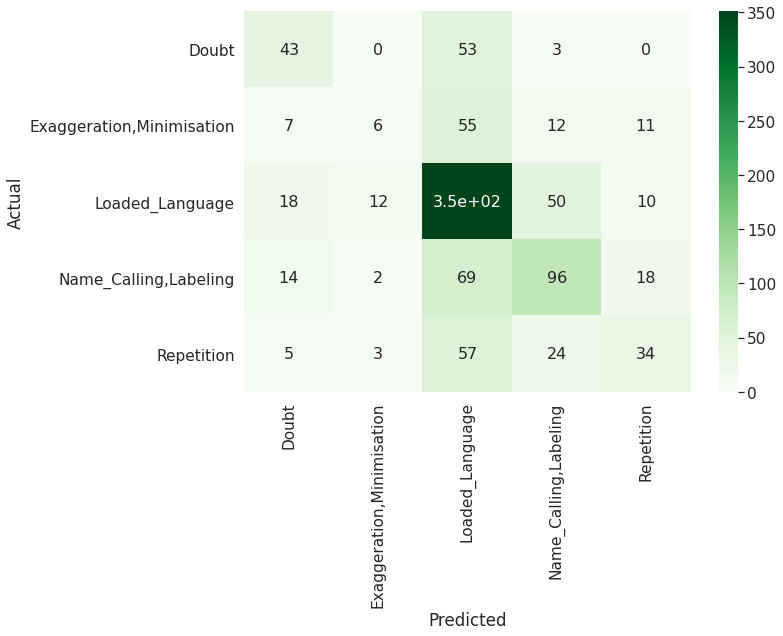

In [0]:
y_test_plot = list(le.inverse_transform(y_test_embed_news))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 16})# font siz

Smoting the X, y of the training data

In [0]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

smote = SMOTE('not majority')

x_smote, y_smote = smote.fit_sample(X_train_embed_news, y_train_embed_news)
x_smote.shape, y_smote.shape

((8410, 100), (8410,))

Testing Logistic regression with smoted embedding data

In [0]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(x_smote, y_smote)

y_pred = clf.predict(X_test_embed_news)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test_embed_news, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test_embed_news, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  49.527806925498425
Precision:  0.45105288800220916
Recall:  0.5051658294877877
F1 score:  0.45825726714149423


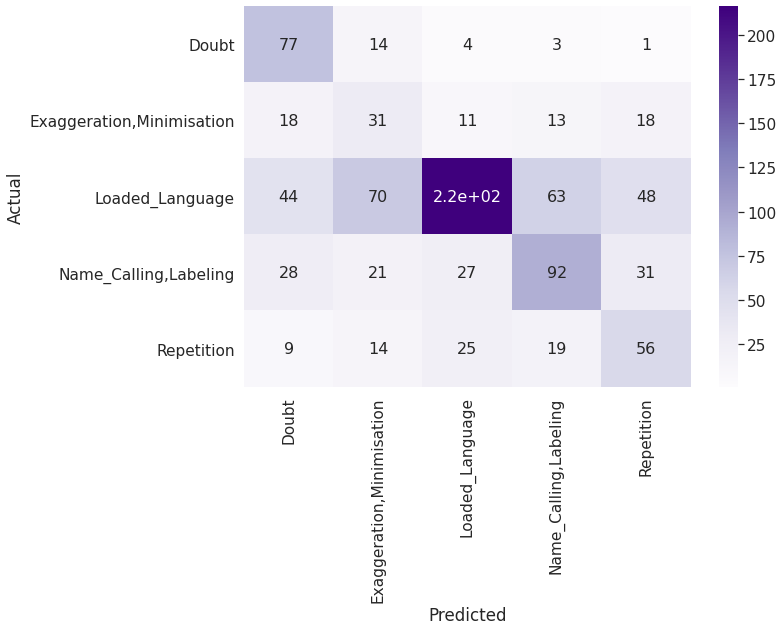

In [0]:
y_test_plot = list(le.inverse_transform(y_test_embed_news))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Purples", annot=True,annot_kws={"size": 16})# font siz

Testing linear regression with smoted embedding data

In [0]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(x_smote, y_smote)

y_pred = sgd.predict(X_test_embed_news)

## Evaluating the model
print("Accuracy: ", accuracy_score(y_test_embed_news, y_pred)* 100)
precision, recall, F1, support = precision_recall_fscore_support(y_test_embed_news, y_pred, average='macro', zero_division = 1)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", F1)

Accuracy:  50.682056663168936
Precision:  0.44596473243236545
Recall:  0.4880983441276195
F1 score:  0.44853266007283904


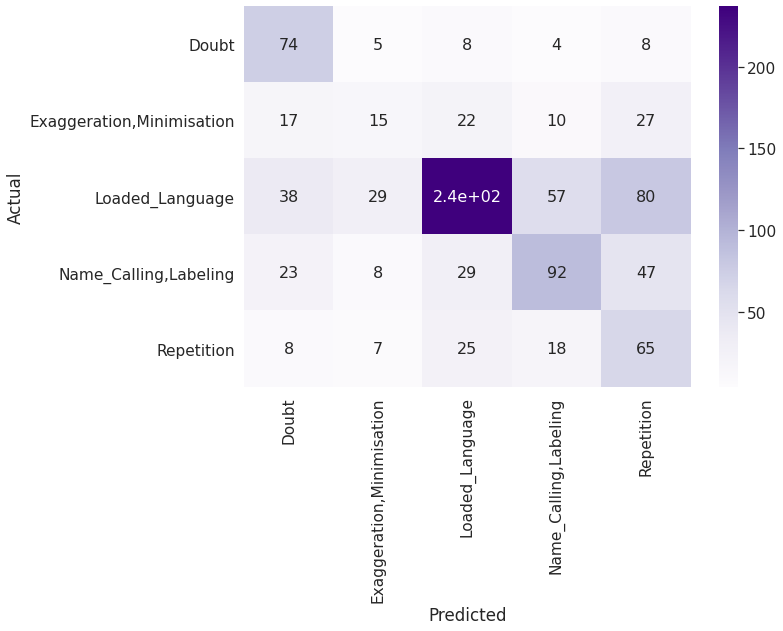

In [0]:
y_test_plot = list(le.inverse_transform(y_test_embed_news))
y_pred_plot = list(le.inverse_transform(y_pred))
data = confusion_matrix(y_test_plot, y_pred_plot)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_plot), index = np.unique(y_test_plot))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Purples", annot=True,annot_kws={"size": 16})# font siz